### Appliction in COVID-19 dataset

In [ ]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import matplotlib.pyplot as plt
import gseapy as gp
import collections as clt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from statannot import add_stat_annotation
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import FloatVector
import collections as clt
import pickle
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import scipy.stats as sci

In [ ]:
os.chdir('/mnt/data1/wangj/AgingScore/GSE171524_NormalLung/')

In [ ]:
### load results data
adata = sc.read_h5ad("/mnt/data1/wangj/AgingScore/GSE171524_NormalLung/Covid.h5ad")
with open('/mnt/data1/wangj/AgingScore/AgingScorePro/Covid_hUSI.pkl', 'rb') as f:
    df = pickle.load(f)
adata.obs = df  

### load raw data

In [ ]:
meta = pd.read_csv('lung_metaData.txt',index_col=0,sep='\t')
### remove 1 row
meta = meta.drop(['TYPE'],axis=0)
meta

In [ ]:
### read counts
files = os.listdir('Counts/')
counts = pd.DataFrame()
cells = []
for file in files:
    tmp = pd.read_csv('Counts/'+file,index_col=0)
    tmp = tmp.T
    cells = cells + tmp.index.tolist()
    counts = pd.concat([counts,tmp],ignore_index=True)                            

In [ ]:
clt.Counter(meta.index.isin(cells))

In [ ]:
counts.index = cells
counts = counts.loc[meta.index,:]

In [ ]:
adata = sc.AnnData(counts)
adata.obs = meta
adata

In [ ]:
adata.var_names_make_unique()

### preprocess data

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
### remove ribosomal and mitochondrial genes
adata = adata[:,~adata.var_names.str.startswith('MT-')]
adata = adata[:,~adata.var_names.str.startswith('RPL')]
adata = adata[:,~adata.var_names.str.startswith('RPS')]
adata

In [ ]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

In [ ]:
adata

In [ ]:
sc.pl.violin(adata, keys='total_counts',groupby='disease__ontology_label',jitter=0.4)

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
adata

In [ ]:
adata[adata.obs.disease__ontology_label == 'COVID-19',:].obs.total_counts.hist(bins=50)
adata[adata.obs.disease__ontology_label == 'normal',:].obs.total_counts.hist(bins=50)
# plt.hist(list(adata[adata.obs.disease__ontology_label == 'COVID-19',:].X.sum(axis=1)))
# plt.hist(list(adata[adata.obs.disease__ontology_label == 'normal',:].X.sum(axis=1)))

In [ ]:
adata.obs.disease__ontology_label.value_counts()

### calculate hUSI

In [ ]:
def cal_hUSI(adata):
    mm_l2 = pd.read_csv('mm_l2.csv',index_col=0)
    genes = set(mm_l2.index) & set(adata.var_names)
    try:
        exp = adata[:,list(genes)].X.todense()
    except:
        exp = adata[:,list(genes)].X
    exp = pd.DataFrame(exp,index=adata.obs_names,columns=list(genes))
    score = []
    for row in range(len(exp)):  
        score.append(mm_l2.w[genes].corr(exp.iloc[row],method='spearman'))
    return score

In [ ]:
hUSI = cal_hUSI(adata)
adata.obs['hUSI'] = hUSI

In [ ]:
df = adata.obs
df['Sample'] = pd.Categorical(df.disease__ontology_label,categories=['normal','COVID-19'],ordered=True)

### visulization

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [ ]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)

In [ ]:
sc.external.pp.bbknn(adata, batch_key='biosample_id')

In [ ]:
sc.tl.umap(adata)

In [ ]:
sns.set(rc={'figure.figsize':(10,9)},font_scale=1.5)
sc.set_figure_params(dpi_save=400)
sns.set_style("white")
# sc.pl.umap(adata, color=['cell_type_main','hUSI'],s=50,palette='tab20',legend_loc= 'on data',save='_Covid19.pdf')

/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


T cells_normal v.s. T cells_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.276e-05 U_stat=3.097e+07
B cells_normal v.s. B cells_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.202e-23 U_stat=6.017e+06
APC-like_normal v.s. APC-like_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.315e-02 U_stat=8.026e+04
Endothelial cells_normal v.s. Endothelial cells_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.143e-39 U_stat=2.698e+06
Epithelial cells_normal v.s. Epithelial cells_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=8.150e+07
Myeloid_normal v.s. Myeloid_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.410e-178 U_stat=4.357e+07
Fibroblasts_normal v.s. Fibroblasts_COVID-19: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.476e-274 U_stat=3.162e+0

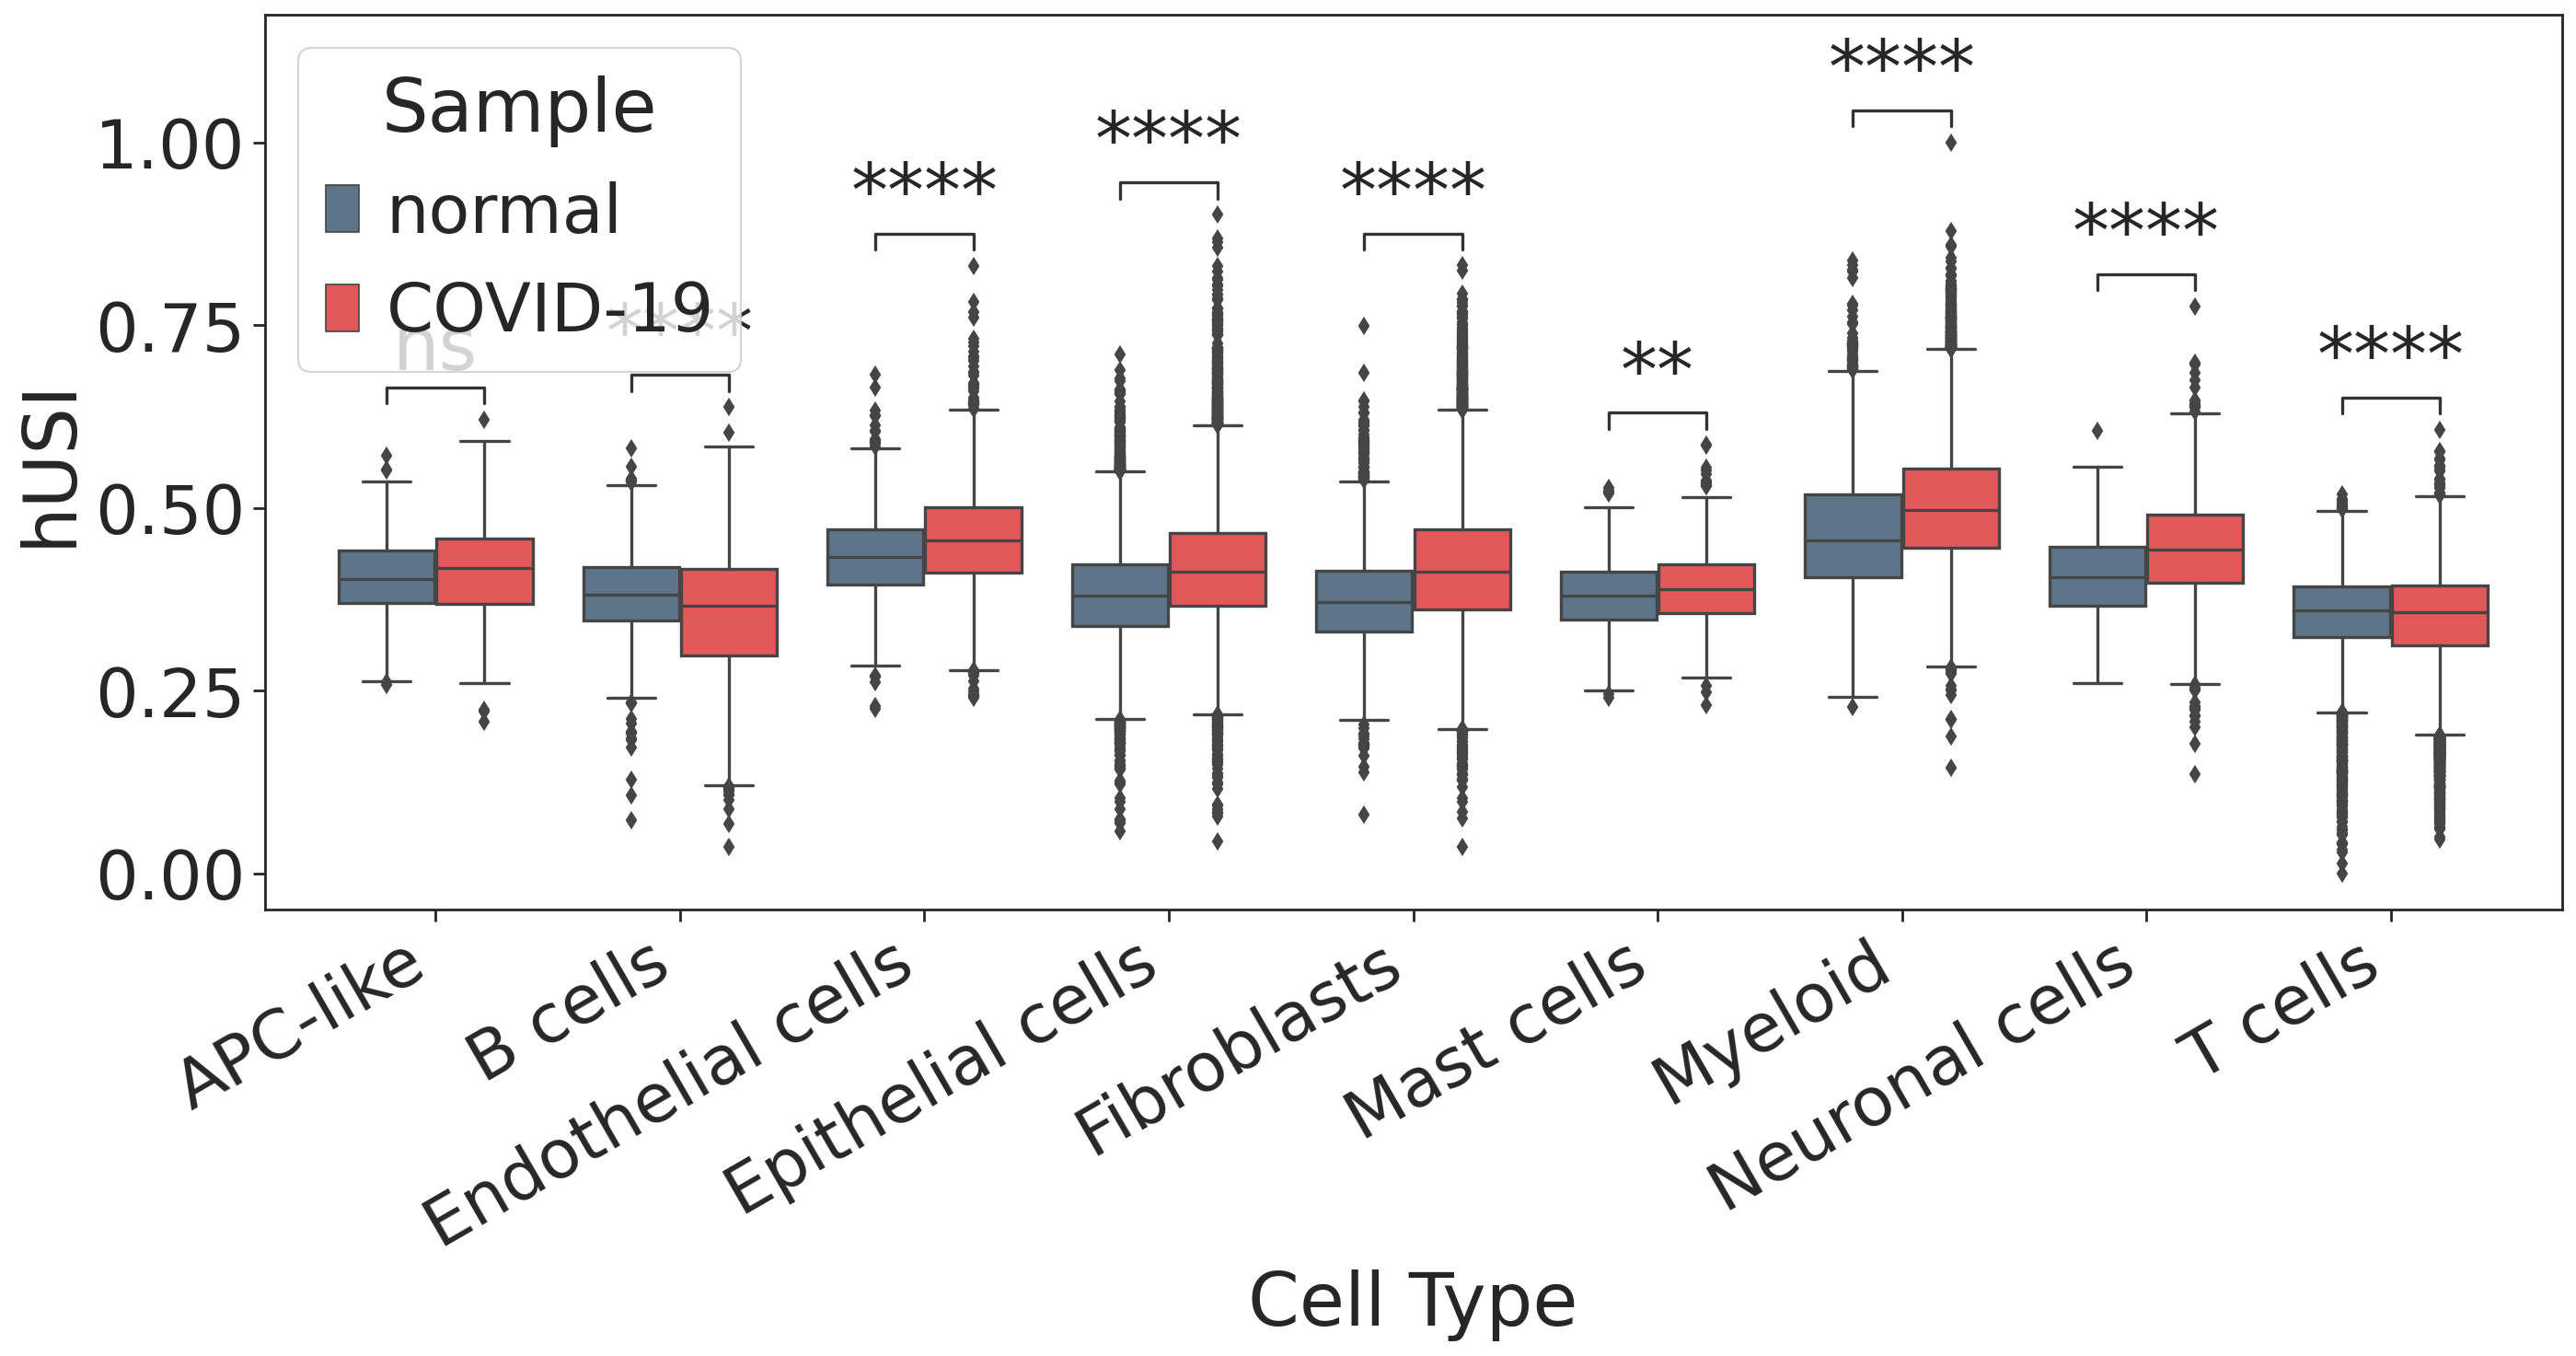

In [235]:
### boxplot significant: hUSI State Clsuter
df = adata.obs
sns.set(rc={'figure.figsize':(20,8)},font_scale=3)
sns.set_style("ticks")
ax = sns.boxplot(hue='Sample',y='hUSI',x = 'cell_type_main',data=df,palette=['#577590','#f94144'])
ax.set(xlabel='Cell Type')
pairs = []
for clu in adata.obs.cell_type_main.unique():
    pair = []
    for state in adata.obs.Sample.unique():
        pair.append((clu,state))
    pairs = pairs+list(itertools.combinations(pair, 2))
add_stat_annotation(ax, data=adata.obs, x="cell_type_main", y="hUSI",hue='Sample',
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,
                    comparisons_correction = "bonferroni",line_offset_to_box=0.02,line_offset=0.01)
plt.xticks(rotation=30,ha='right')
plt.rc('font',family='Arial', size=15)
# plt.savefig("HUSI/Figures/model/Covid_hUSI.pdf",dpi = 400,bbox_inches = 'tight')

### classify cell sate based on hUSI

In [ ]:
robjects.r('set.seed(223)')
mclust = importr('mclust')

data = adata.obs['hUSI'].tolist()
data = [np.log2(1+i)/np.log2(1-i) for i in data]
r_data = FloatVector(data)

result = mclust.Mclust(r_data)  
clusters = result.rx2('classification')
clusters = list(clusters)
print(clt.Counter(clusters))

In [ ]:
adata.obs['age_class'] = pd.Categorical(['C'+str(int(i)) for i in clusters])

In [ ]:
adata.obs['age_class'].value_counts()

In [ ]:
### define a minmax function
def minmax(X):
    X_scaled = (X-np.min(X))/(np.max(X)-np.min(X))
    return X_scaled

### visiulize hUSI class in each cell type

In [ ]:
import matplotlib.pyplot as plt

# Get the colormap
cmap = plt.get_cmap('tab20')

# Number of colors in the colormap
num_colors = cmap.N

# Print each color in hex format
for i in range(num_colors):
    rgb = cmap(i)[:3]  # will return rgba, we take only rgb
    hex_color = matplotlib.colors.rgb2hex(rgb)
    print(f"'{hex_color}'",end=',')


/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


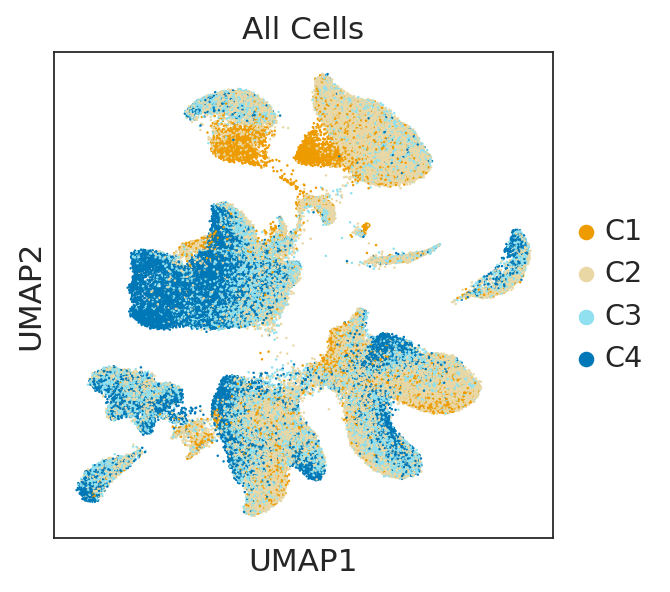

In [181]:
### all cells
sns.set(rc={'figure.figsize':(20,20)},font_scale=1.5)
sc.set_figure_params(dpi_save=300)
sns.set_style("white")
sc.pl.umap(adata, color=['age_class'],s=5,palette=['#ee9b00','#e9d8a6','#90e0ef','#0077b6'],save='all.png',show = True,title='All Cells')

In [ ]:
### re-cluster each cell type
adata_list = {}
for clu in np.unique(adata.obs.cell_type_main):
    adata_sub = adata[adata.obs.cell_type_main == clu,:]
    sc.pp.highly_variable_genes(adata_sub, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata_sub.raw = adata_sub
    adata_sub = adata_sub[:, adata_sub.var.highly_variable]
    adata_sub = adata_sub[:, adata_sub.var.highly_variable]
    sc.pp.scale(adata_sub, max_value=10)
    sc.tl.pca(adata_sub, svd_solver='arpack')
    sc.pp.neighbors(adata_sub)
    sc.external.pp.bbknn(adata_sub, batch_key='biosample_id',neighbors_within_batch=1)
    sc.tl.umap(adata_sub)
    adata_list[clu] = adata_sub

In [ ]:
os.chdir('/home/wangjing/wangj/codebase/HUSI/Figures/covid-19')

In [170]:
adata_list.keys()

dict_keys(['APC-like', 'B cells', 'Endothelial cells', 'Epithelial cells', 'Fibroblasts', 'Mast cells', 'Myeloid', 'Neuronal cells', 'T cells'])

In [206]:
clu = 'T cells'
adata_sub = adata_list[clu]
adata_sub

AnnData object with n_obs × n_vars = 16751 × 3240
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'group', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'sex', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h', 'n_genes', 'n_genes_by_counts', 'total_counts', 'Sample', 'hUSI', 'age_class'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_main_colors', 'disease__ontology_label_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'age_class_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [207]:
sns.set(rc={'figure.figsize':(8,8)},font_scale=3)
sns.set_style("white")
# for clu in np.unique(adata.obs.cell_type_main):

sc.pl.umap(adata_sub, color=['age_class'],s=50,palette=['#ee9b00','#e9d8a6','#90e0ef','#0077b6'],title = clu,show=False,save=clu+'.png')

/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/wangjing/miniconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'T cells'}, xlabel='UMAP1', ylabel='UMAP2'>

In [178]:
df = adata.obs
df['hUSI'] = minmax(df.hUSI)
# df.to_csv('/home/wangjing/wangj/codebase/HUSI/Figures/revison/COVID-19.csv')

/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default 

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C1 v.s. C2: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=0.000e+00
C2 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=0.000e+00
C3 v.s. C4: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.412e-99 U_stat=0.000e+00


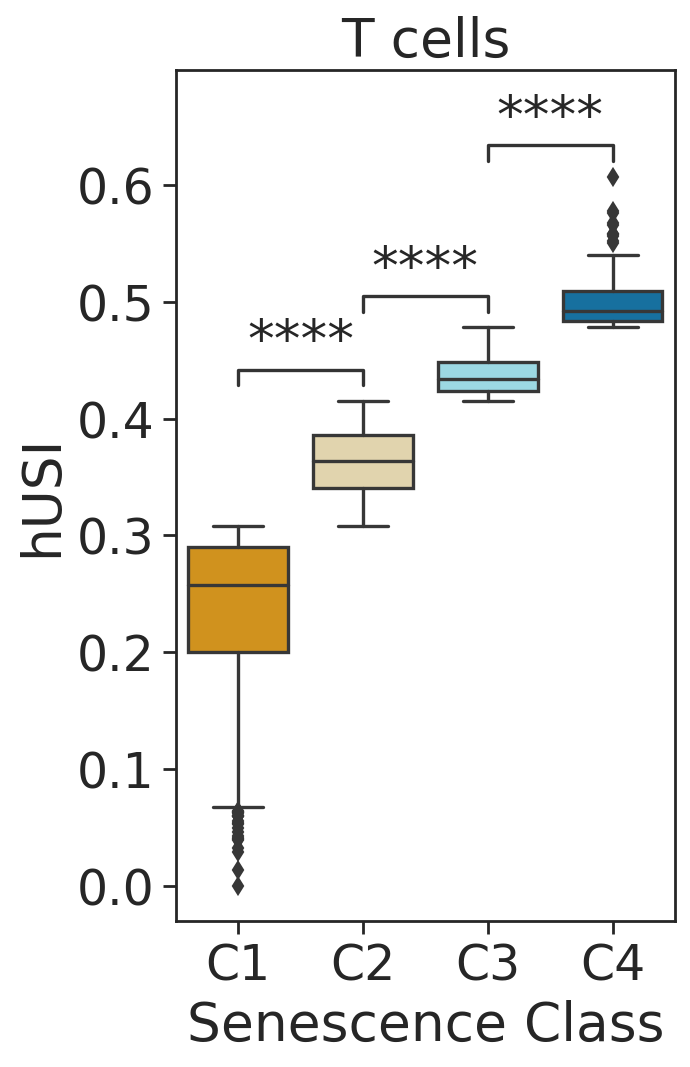

In [208]:
### plot hUSI level of age class
sns.set(rc={'figure.figsize':(4,7)},font_scale=2,style='white')
sns.set_style("ticks")
ax = sns.boxplot(x='age_class',y='hUSI',data=df[df.index.isin(adata_sub.obs_names)],palette=['#ee9b00','#e9d8a6','#90e0ef','#0077b6'])
plt.xlabel('Senescence Class')
pairs = [('C2','C1'),('C3','C2'),('C4','C3')]
add_stat_annotation(ax, data=df[df.index.isin(adata_sub.obs_names)], x="age_class", y="hUSI",
                    box_pairs=pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2,
                    comparisons_correction = "bonferroni",line_offset_to_box=0.02,line_offset=0.01)
### add title
plt.title(clu)
# plt.savefig("HUSI/Figures/model/Covid_hUSI_class.pdf",dpi = 400,bbox_inches = 'tight')
plt.savefig("/home/wangjing/wangj/codebase/HUSI/Figures/covid-19/figures/"+clu+".png",dpi = 400,bbox_inches = 'tight')

### SASP expression level of C1~C4

In [242]:
SASP = pd.read_csv('/mnt/data1/wangj/AgingScore/AgingScorePro/SASP.csv')
SASP

,genes
0,CDKN1A
1,LMNB1
2,MKI67
3,DHFR
4,IL1A
5,IL6
6,IL8
7,CCL2
8,CXCL10
9,MMP3


In [249]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        idx = gene_symbols
    else:
        idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [248]:
# adata_plot = adata.raw.to_adata()
adata_plot = adata.copy()
adata_plot

AnnData object with n_obs × n_vars = 116313 × 32511
    obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'group', 'cell_type_main', 'cell_type_intermediate', 'cell_type_fine', 'initial_clustering', 'age', 'sex', 'recorded_race', 'recorded_ethnicity', 'intubation_days', 'interval_death_symptoms_onset_days', 'pmi_h', 'n_genes', 'n_genes_by_counts', 'total_counts', 'Sample', 'hUSI', 'age_class'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_main_colors', 'disease__ontology_label_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'age_class_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [246]:
exp

,C1,C2,C3,C4
CDKN1A,NaN,NaN,NaN,NaN
LMNB1,NaN,NaN,NaN,NaN
MKI67,NaN,NaN,NaN,NaN
DHFR,NaN,NaN,NaN,NaN
IL1A,NaN,NaN,NaN,NaN
IL6,NaN,NaN,NaN,NaN
CCL2,NaN,NaN,NaN,NaN
CXCL10,NaN,NaN,NaN,NaN
MMP3,NaN,NaN,NaN,NaN
MMP9,NaN,NaN,NaN,NaN


/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_54920/1302019431.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = adata.obs.groupby(group_key)
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/wangjing/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1118: FutureWarning: is_categorical_dtype is deprecated and will be rem

ValueError: The condensed distance matrix must contain only finite values.

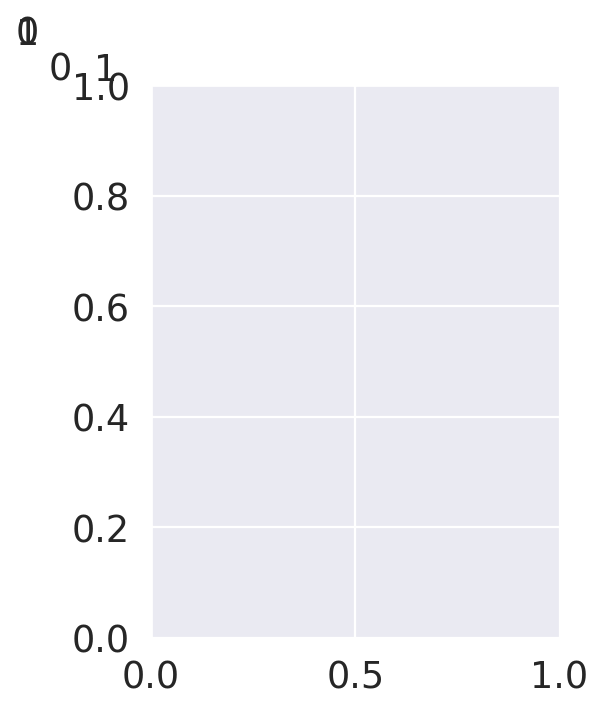

In [245]:
exp = grouped_obs_mean(adata_plot, group_key = 'age_class', layer=None, gene_symbols=SASP.genes)

sns.set(font_scale=1.5)
sns.clustermap(exp,cmap='Reds',col_cluster=False,row_cluster=True,figsize=(4,5),standard_scale=0,linecolor='grey',linewidths=0.1, cbar_pos=(0.9, .3, .03, .4),dendrogram_ratio=(.1, 0))
# plt.savefig("HUSI/Figures/model/Covid_SASP.pdf",dpi = 400,bbox_inches = 'tight')

### fraction of C1~C4 in normal and COVID-19 samples

In [209]:
df = adata.obs

In [210]:
df_plot = df[['age_class','disease__ontology_label']].groupby(['age_class','disease__ontology_label']).size().reset_index().rename(columns={0:'count'})
df_plot['Fraction'] = df_plot['count'] / df_plot.groupby(['disease__ontology_label'])['count'].transform('sum')
df_plot['Sample'] = pd.Categorical(df_plot['disease__ontology_label'].apply(lambda x: 'COVID-19' if x == 'COVID-19' else 'Normal'),categories=['Normal','COVID-19'],ordered=True)
df_plot

/tmp/ipykernel_54920/3792870946.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df[['age_class','disease__ontology_label']].groupby(['age_class','disease__ontology_label']).size().reset_index().rename(columns={0:'count'})
/tmp/ipykernel_54920/3792870946.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot['Fraction'] = df_plot['count'] / df_plot.groupby(['disease__ontology_label'])['count'].transform('sum')


,age_class,disease__ontology_label,count,Fraction,Sample
0,C1,COVID-19,6724,0.084434,COVID-19
1,C1,normal,3968,0.108188,Normal
2,C2,COVID-19,29081,0.365174,COVID-19
3,C2,normal,20506,0.559097,Normal
4,C3,COVID-19,20223,0.253943,COVID-19
5,C3,normal,8280,0.225755,Normal
6,C4,COVID-19,23608,0.296449,COVID-19
7,C4,normal,3923,0.106961,Normal


In [211]:
df_plot2 = df[['age_class','hUSI']].groupby('age_class').mean().reset_index().rename(columns={0:'hUSI'})
df_plot2

/tmp/ipykernel_54920/1578802652.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot2 = df[['age_class','hUSI']].groupby('age_class').mean().reset_index().rename(columns={0:'hUSI'})


,age_class,hUSI
0,C1,0.258814
1,C2,0.368147
2,C3,0.444768
3,C4,0.545590


/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


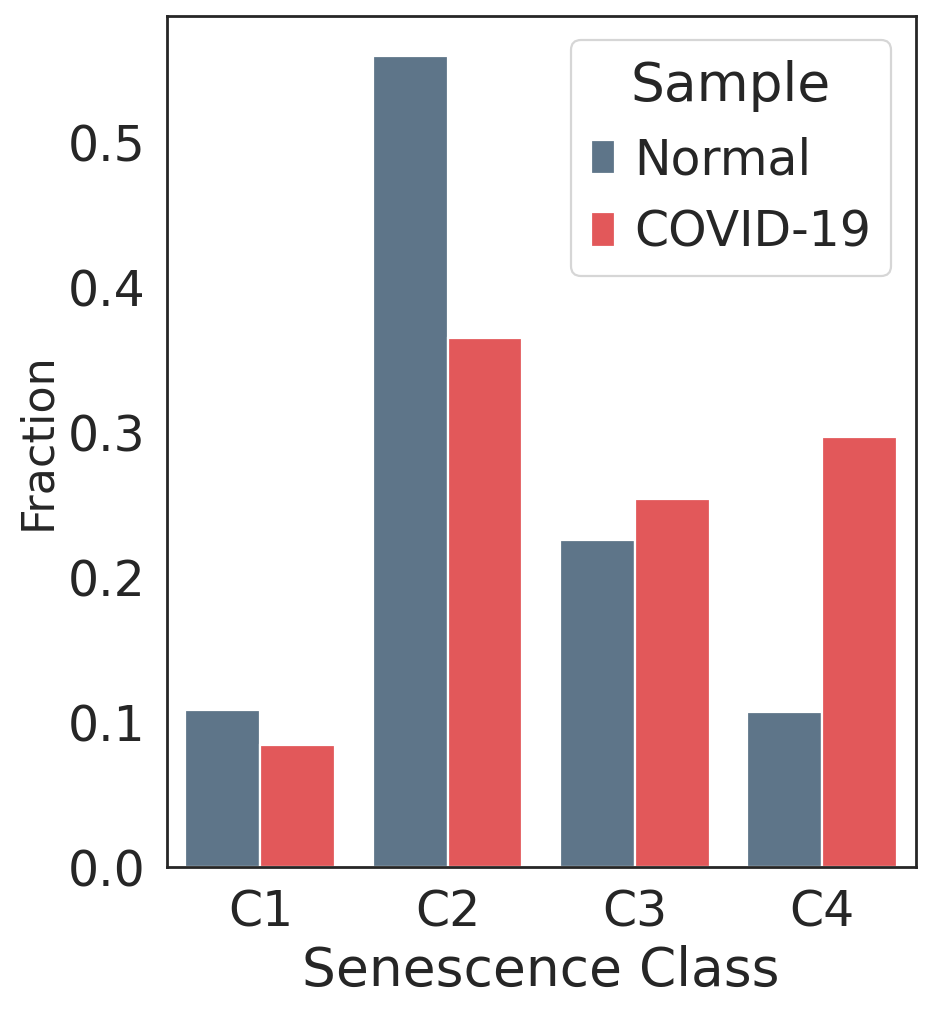

In [212]:
sns.set(rc={'figure.figsize':(6,7)},font_scale=2)
sns.set_style("white")
ax1 = sns.barplot(hue='Sample',y='Fraction',x='age_class',data=df_plot,palette=['#577590','#f94144'])
plt.xlabel('Senescence Class')
ax1.set_ylabel('Fraction', fontsize='20')
plt.rc('font',family='Arial', size=15)
# plt.savefig("HUSI/Figures/model/Covid_class.pdf",dpi = 500,bbox_inches = 'tight')

### correlation between days to death and C4 fration in COVID-19 samples

In [218]:
### senescence fraction in each cell type
sene_fraction = {}
for c in adata.obs.cell_type_main.unique():
    df = adata.obs
    df = df[df.cell_type_main == c]
    df = df[df.disease__ontology_label == 'COVID-19']
    df_plot = df[['age_class','interval_death_symptoms_onset_days']].groupby(['age_class','interval_death_symptoms_onset_days']).size().reset_index().rename(columns={0:'count'})
    df_plot['Senescence fraction'] = df_plot['count'] / df_plot.groupby(['interval_death_symptoms_onset_days'])['count'].transform('sum')
    df_plot = df_plot[df_plot.age_class == 'C4']
    df_plot['Age'] = df[['age','interval_death_symptoms_onset_days']].groupby(['interval_death_symptoms_onset_days']).mean().reset_index().rename(columns={0:'age'}).age.values
    df_plot.dropna(inplace=True)
    df_plot['Days to Death'] = df_plot['interval_death_symptoms_onset_days']
    df_plot['cell_type_main'] = c
    sene_fraction[c] = df_plot

/tmp/ipykernel_54920/1599502759.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df[['age_class','interval_death_symptoms_onset_days']].groupby(['age_class','interval_death_symptoms_onset_days']).size().reset_index().rename(columns={0:'count'})
/tmp/ipykernel_54920/1599502759.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df[['age_class','interval_death_symptoms_onset_days']].groupby(['age_class','interval_death_symptoms_onset_days']).size().reset_index().rename(columns={0:'count'})
/tmp/ipykernel_54920/1599502759.py:7: FutureWarning: The default of observed=False is deprecated and

/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

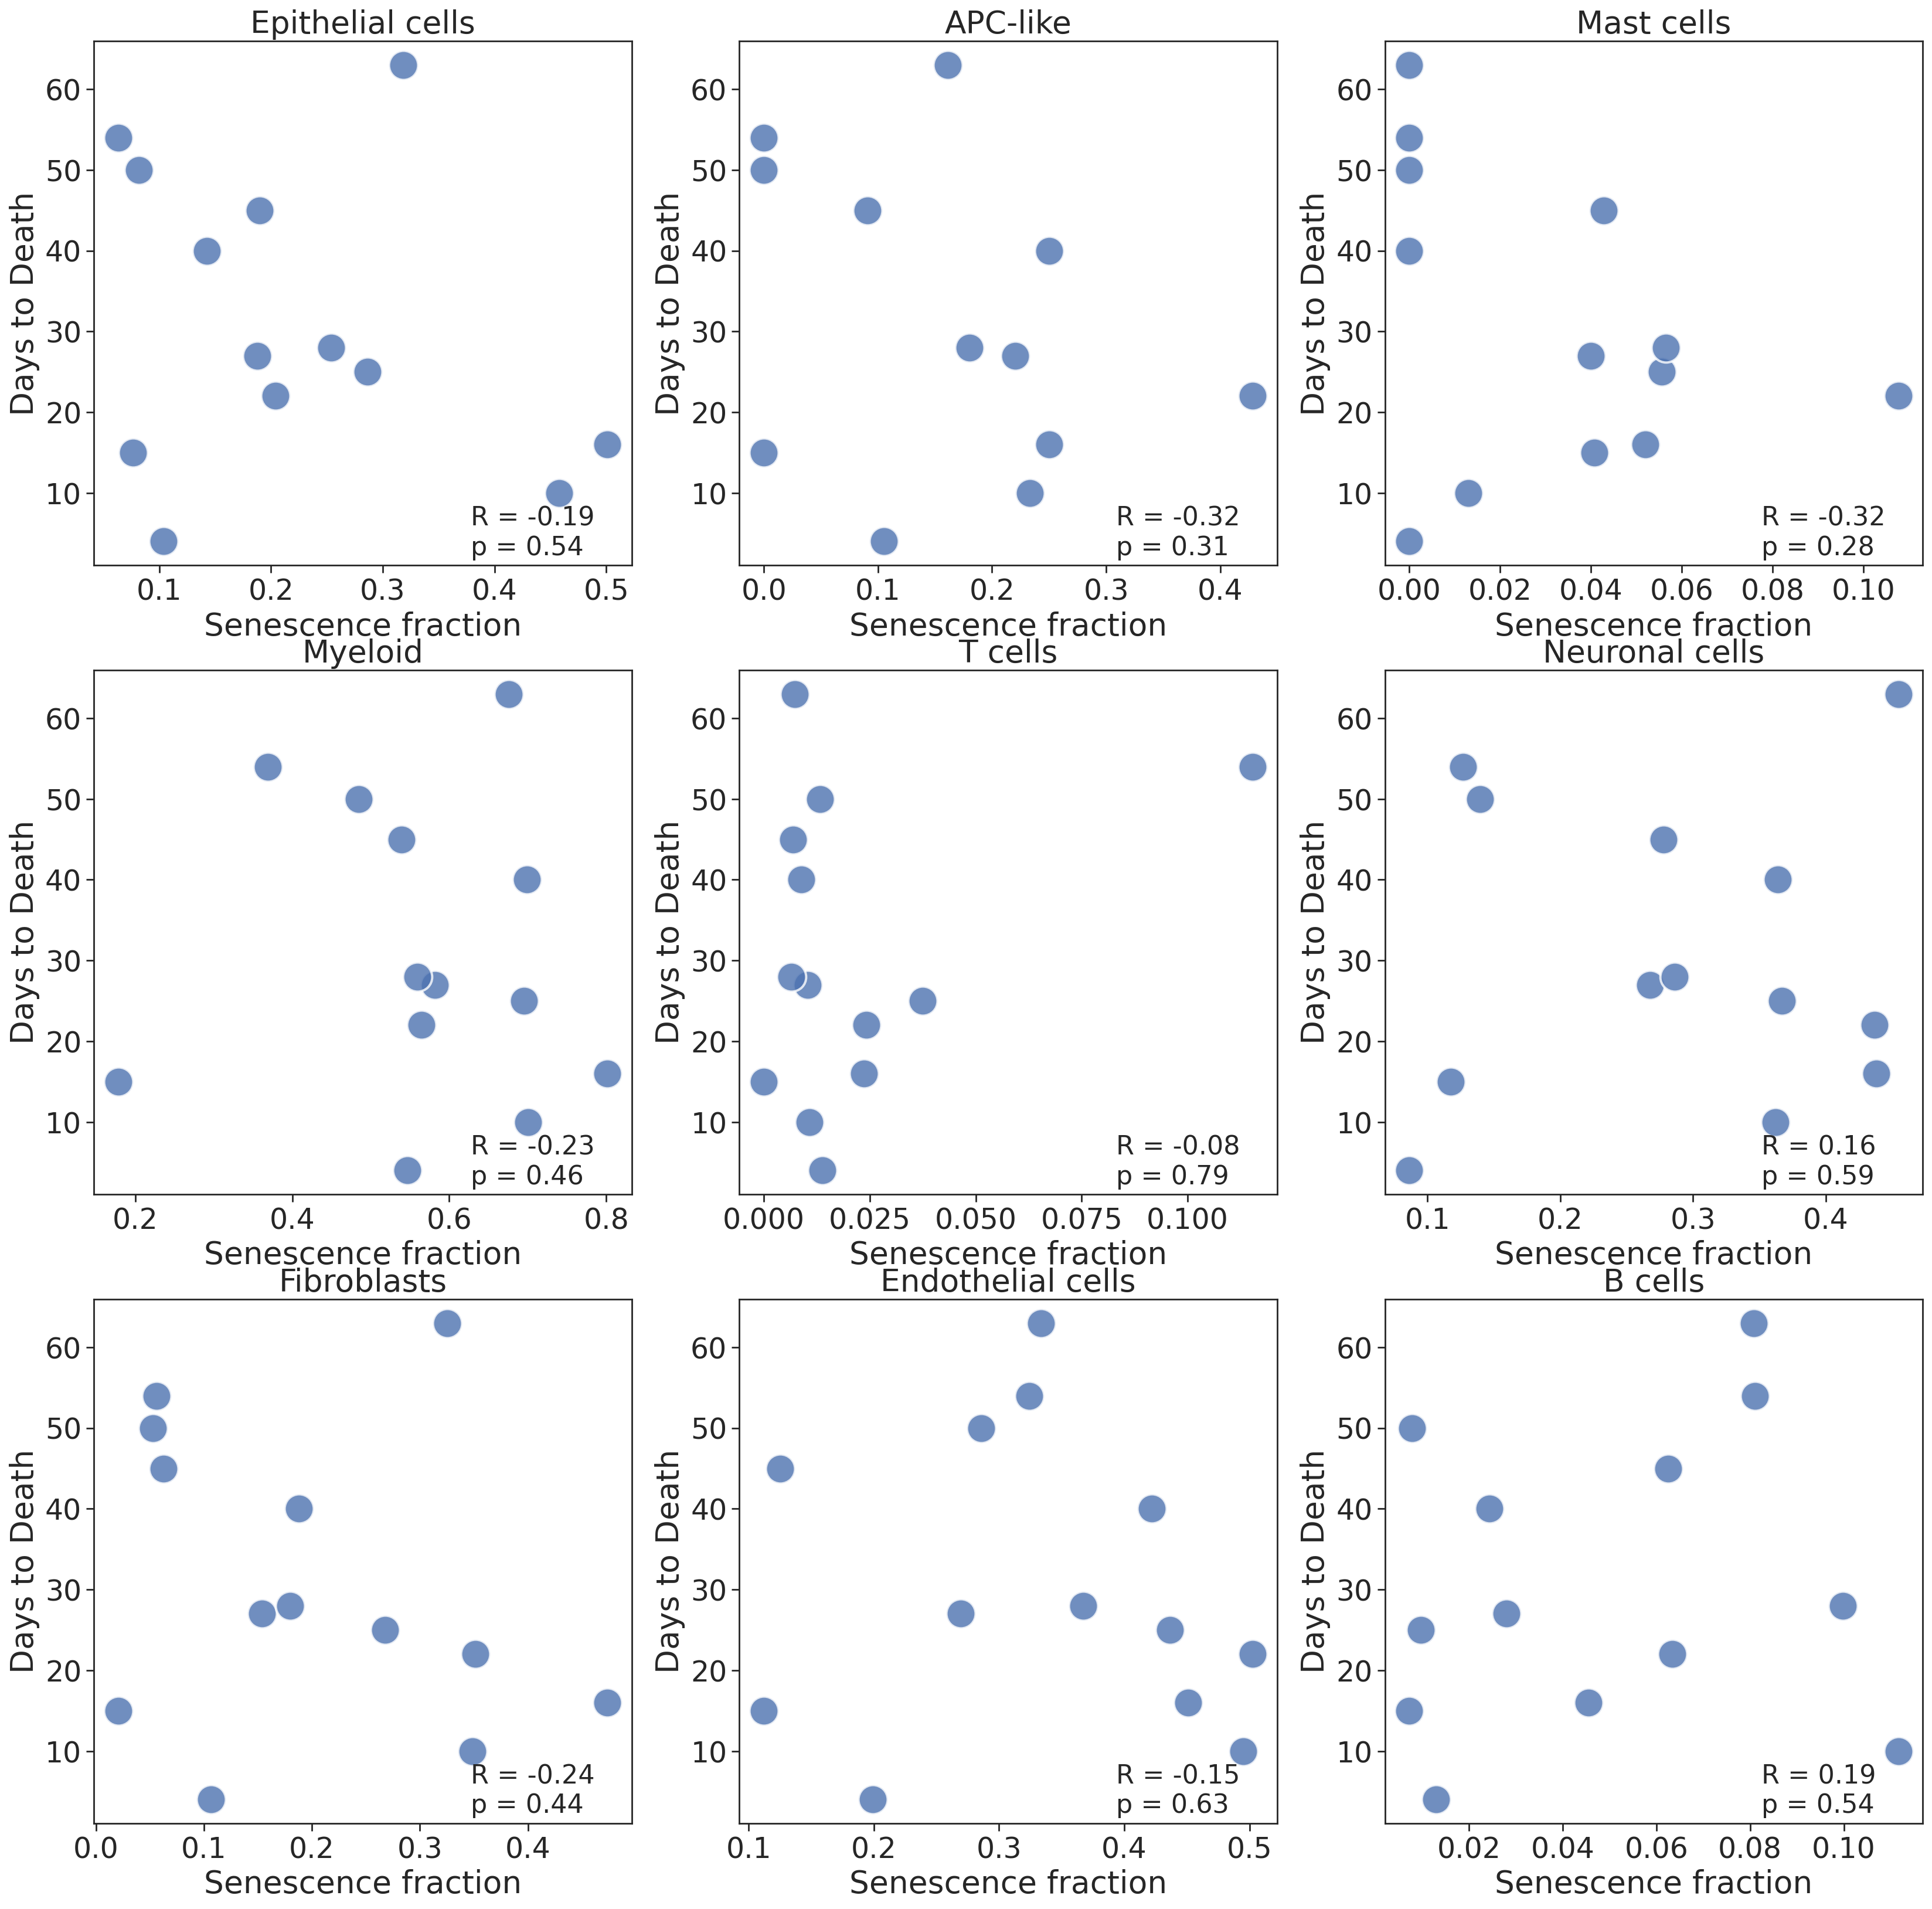

In [234]:
### plot correlation between senescence fraction and DTD in each cell type
fig, axs = plt.subplots(3,3,figsize = (25,25))
i = 0
for k in sene_fraction.keys():
    sns.set_style("ticks")
    X = 'Senescence fraction'
    Y = 'Days to Death'
    ax = sns.scatterplot(x=X,y=Y,data=sene_fraction[k],s=500,alpha = 0.8,ax=axs[i%3,i//3])
    cor = sci.spearmanr(sene_fraction[k][X],sene_fraction[k][Y])
    c = cor.correlation
    p = cor.pvalue
    ax.annotate('R = '+str(round(c,2))+'\n'+'p = '+str(round(p,2)), xy=(0.7, 0.02), xycoords='axes fraction',fontsize=20)
    ax.title.set_text(k)
    i += 1

In [236]:
adata.obs.cell_type_main.unique()

['Epithelial cells', 'Myeloid', 'Fibroblasts', 'APC-like', 'T cells', 'Endothelial cells', 'Mast cells', 'Neuronal cells', 'B cells']
Categories (9, object): ['APC-like', 'B cells', 'Endothelial cells', 'Epithelial cells', ..., 'Mast cells', 'Myeloid', 'Neuronal cells', 'T cells']

In [238]:
df = adata.obs
df = df[~df.cell_type_main.isin(['APC-like','B cells','T cells'])]
df = df[df.disease__ontology_label == 'COVID-19']
df_plot = df[['age_class','interval_death_symptoms_onset_days']].groupby(['age_class','interval_death_symptoms_onset_days']).size().reset_index().rename(columns={0:'count'})
df_plot['Senescence fraction'] = df_plot['count'] / df_plot.groupby(['interval_death_symptoms_onset_days'])['count'].transform('sum')
df_plot = df_plot[df_plot.age_class == 'C4']
df_plot['Age'] = adata.obs[['age','interval_death_symptoms_onset_days']].groupby(['interval_death_symptoms_onset_days']).mean().reset_index().rename(columns={0:'age'}).age.values
df_plot.dropna(inplace=True)
df_plot['Days to Death'] = df_plot['interval_death_symptoms_onset_days']
df_plot

/tmp/ipykernel_54920/51422267.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot = df[['age_class','interval_death_symptoms_onset_days']].groupby(['age_class','interval_death_symptoms_onset_days']).size().reset_index().rename(columns={0:'count'})


,age_class,interval_death_symptoms_onset_days,count,Senescence fraction,Age,Days to Death
42,C4,4.0,546,0.217530,70.0,4.0
43,C4,10.0,1484,0.518519,83.0,10.0
45,C4,15.0,274,0.084178,79.0,15.0
46,C4,16.0,2468,0.643043,73.0,16.0
47,C4,22.0,2714,0.403809,80.0,22.0
48,C4,25.0,1557,0.375452,65.0,25.0
49,C4,27.0,2221,0.374916,75.863915,27.0
50,C4,28.0,4888,0.375711,71.936752,28.0
51,C4,40.0,597,0.253934,69.0,40.0
52,C4,45.0,688,0.305642,68.0,45.0


/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/wangjing/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.7, 0.02, 'R = -0.16\np = 0.59')

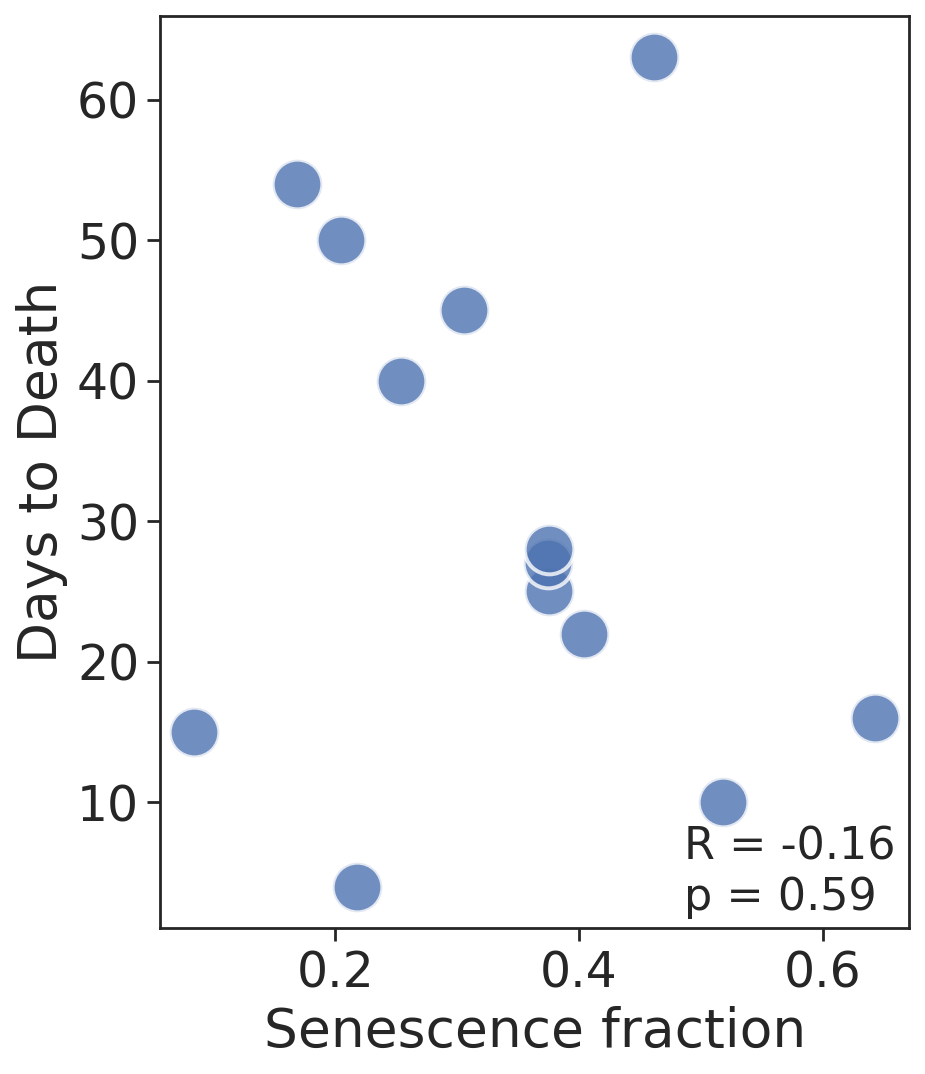

In [240]:
sns.set(rc={'figure.figsize':(6,7.5)},font_scale=2)
sns.set_style("ticks")
X = 'Senescence fraction'
Y = 'Days to Death'
ax=sns.scatterplot(x=X,y=Y,data=df_plot,s=500,alpha = 0.8)
cor = sci.spearmanr(df_plot[X],df_plot[Y])
c = cor.correlation
p = cor.pvalue
plt.annotate('R = '+str(round(c,2))+'\n'+'p = '+str(round(p,2)), xy=(0.7, 0.02), xycoords='axes fraction',fontsize=20)
# plt.savefig("HUSI/Figures/model/Covid_DTD.pdf",dpi = 500,bbox_inches = 'tight')

In [ ]:
### leave-out
cc = []
pp = []
for i in df_plot.index:
    df_plot_leave_out = df_plot.copy()
    df_plot_leave_out.drop(i,inplace=True)
    cor = sci.spearmanr(df_plot_leave_out['Senescence fraction'],df_plot_leave_out['Days to Death'])
    c = cor.correlation
    p = cor.pvalue
    cc.append(c)
    pp.append(p)
    print(i,c,p)

In [ ]:
### lines plot 
plt.figure(figsize=(10,6))
sns.set_style('ticks')
df_plot['R'] = cc
df_plot['P'] = pp
# plt.plot(df_plot['Days to Death'],df_plot['Senescence fraction'])
plt.plot(df_plot['Days to Death'],df_plot['R'],'o-',label = 'R')
plt.plot(df_plot['Days to Death'],df_plot['P'],'o-',label = 'p')
plt.legend()
plt.yticks(np.arange(-0.5,1,0.1))
plt.xticks(np.arange(0,70,5))
plt.show()

In [ ]:
### cell class in all biosample
df = adata.obs
df = df[df.disease__ontology_label == 'COVID-19']
df['biosample_id'] = df['biosample_id'].cat.remove_unused_categories()
df_plot = df[['age_class','biosample_id']].groupby(['age_class','biosample_id']).size().reset_index().rename(columns={0:'count'})
df_plot['Fraction'] = df_plot['count'] / df_plot.groupby(['biosample_id'])['count'].transform('sum')
df_plot.dropna(inplace = True)
Ages = df[["biosample_id", "age"]].set_index("biosample_id").to_dict(orient='dict')['age']
DTDs = df[["biosample_id", "interval_death_symptoms_onset_days"]].set_index("biosample_id").to_dict(orient='dict')['interval_death_symptoms_onset_days']
IDs = df[["biosample_id", "sex"]].set_index("biosample_id").to_dict(orient='dict')['sex']
df_plot['Age'] = [Ages[s] for s in df_plot['biosample_id']]
df_plot['Days to Death'] = [DTDs[s] for s in df_plot['biosample_id']]
df_plot['sex'] = [IDs[s] for s in df_plot['biosample_id']]
df_plot.dropna(inplace = True)
df_plot.sort_values('count',inplace=True)
df_plot['biosample_id'] = df_plot['biosample_id'].cat.remove_unused_categories()
### sort biosample_id by days to death
biosample_id = df_plot[['biosample_id','Days to Death']].drop_duplicates().sort_values('Days to Death')['biosample_id'].tolist()
df_plot['biosample_id'] = pd.Categorical(df_plot['biosample_id'],categories=biosample_id,ordered=True)
df_plot

In [ ]:
### plot barplot for Fraction in each biosample_id
sns.set(rc={'figure.figsize':(12,7)},font_scale=2)
sns.set_style("white")
sns.barplot(x='biosample_id',y='Fraction',hue='age_class',data=df_plot,palette='Reds')
plt.xticks(rotation=30,ha='right')
plt.legend(title='Senescence\nClass',loc='upper right',bbox_to_anchor=(1.3, 1))
plt.show()

In [ ]:
### remove outlier
df_plot_rm = df_plot[~df_plot['Days to Death'].isin([4,15])]
df_plot_rm

In [ ]:
sns.set(rc={'figure.figsize':(6,7.5)},font_scale=2)
sns.set_style("ticks")
X = 'Age'
Y = 'Days to Death'
ax=sns.scatterplot(x=X,y=Y,data=df_plot_rm,s=500,alpha = 0.8)
cor = sci.spearmanr(df_plot_rm[X],df_plot_rm[Y])
c = cor.correlation
p = cor.pvalue
plt.annotate(f'R = {c:.2f}\np = {p:.4f}', xy=(0.05, 0.02), xycoords='axes fraction',fontsize=20)
# plt.savefig("HUSI/Figures/model/Covid_DTD.pdf",dpi = 500,bbox_inches = 'tight')

In [ ]:
### robust linear regression
from sklearn import linear_model
np.random.seed(233)
ransac = linear_model.RANSACRegressor()
X = df_plot[['Age','Senescence fraction']].values.reshape(-1,2)
y = df_plot['Days to Death'].values
ransac.fit(X, y)

line_X = np.column_stack((np.linspace(X[:,0].min(), X[:,0].max(),num=100),np.linspace(X[:,1].min(), X[:,1].max(),num=100)))
line_y_ransac = ransac.predict(line_X)

intercept = ransac.estimator_.intercept_
slope = ransac.estimator_.coef_

In [ ]:
lw = 2
sns.set(rc={'figure.figsize':(7,8)},font_scale=2)
sns.set_style("ticks")
ax=sns.scatterplot(x='Senescence fraction',y='Days to Death',data=df_plot,hue='Senescence fraction',s=500,alpha = 0.8)
plt.annotate(f'y = ({slope[0]:.2f}*x_age)+({slope[1]:.2f}*x_sf)+{intercept:.2f}', xy=(0.2, 0.85), xycoords='axes fraction',fontsize=15)
plt.legend([],[], frameon=False)

plt.plot(
    np.linspace(X[:,1].min(), X[:,1].max(),num=100),
    line_y_ransac,
    color="cornflowerblue",
    linewidth=lw,
    label="RANSAC regressor",
)

### fraction difference of C1~C4 (COVID-19 - normal) across all cell subtypes

In [ ]:
df = adata.obs[['cell_type_main','age_class']].groupby(['cell_type_main','age_class']).size().reset_index().rename(columns={0:'count'})
df.to_csv('/home/wangjing/wangj/codebase/HUSI/Figures/revison/cell_type.csv',index=False)

In [ ]:
### by disease
group = 'cell_type_fine'
df = adata[adata.obs.disease__ontology_label == 'COVID-19'].obs[[group,'age_class']].groupby([group,'age_class']).size().reset_index().rename(columns={0:'count'})
df['Fraction'] = df['count'] / df.groupby([group])['count'].transform('sum')
df1 = df
df = adata[adata.obs.disease__ontology_label == 'normal'].obs[[group,'age_class']].groupby([group,'age_class']).size().reset_index().rename(columns={0:'count'})
df['Fraction'] = df['count'] / df.groupby([group])['count'].transform('sum')
df2= df

In [ ]:
### plot fraction of each cell types in C1~C4 
df_plot = df1
sns.set_style("ticks")
N = len(df1[group].unique())
ind = np.arange(N)
width = 0.35
fig, ax = plt.subplots(figsize=(14, 4))
rects1 = ax.bar(ind, df_plot[df_plot.age_class == 'C1'].Fraction, width, color='#F4CEBE')
rects2 = ax.bar(ind, df_plot[df_plot.age_class == 'C2'].Fraction, width, color='#EA947C',bottom=df_plot[df_plot.age_class == 'C1'].Fraction)
rects3 = ax.bar(ind, df_plot[df_plot.age_class == 'C3'].Fraction, width, color='#D9584A',bottom=df_plot[df_plot.age_class == 'C1'].Fraction.values+df_plot[df_plot.age_class == 'C2'].Fraction.values)
rects4 = ax.bar(ind, df_plot[df_plot.age_class == 'C4'].Fraction, width, color='#A7292D',bottom=1-df_plot[df_plot.age_class == 'C4'].Fraction)
ax.set_ylabel('Fraction', fontsize='20')
ax.set_xticks(ind)
ax.set_xticklabels(df_plot[group].unique(),rotation=90,ha='center')
ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('C1','C2','C3','C4'),fontsize=15,loc='upper right',bbox_to_anchor=(1.1, 1))
# plt.title('COVID-19',fontsize=20)
plt.title('Normal',fontsize=20)
# plt.savefig("HUSI/Figures/model/Covid_celltype_Fra_N.pdf",dpi = 500,bbox_inches = 'tight')

In [ ]:
### plot fraction of each cell types in C1~C4 
df_plot = df
sns.set_style("ticks")
N = len(df[group].unique())
ind = np.arange(N)
width = 0.35
# fig, ax = plt.subplots(figsize=(14, 4))
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(ind, df_plot[df_plot.age_class == 'C1'].Fraction, width, color='#F4CEBE')
rects2 = ax.bar(ind, df_plot[df_plot.age_class == 'C2'].Fraction, width, color='#EA947C',bottom=df_plot[df_plot.age_class == 'C1'].Fraction)
rects3 = ax.bar(ind, df_plot[df_plot.age_class == 'C3'].Fraction, width, color='#D9584A',bottom=df_plot[df_plot.age_class == 'C1'].Fraction.values+df_plot[df_plot.age_class == 'C2'].Fraction.values)
rects4 = ax.bar(ind, df_plot[df_plot.age_class == 'C4'].Fraction, width, color='#A7292D',bottom=1-df_plot[df_plot.age_class == 'C4'].Fraction)
ax.set_ylabel('Fraction', fontsize='20')
ax.set_xticks(ind)
ax.set_xticklabels(df_plot[group].unique(),rotation=90,ha='center')
ax.legend((rects1[0], rects2[0],rects3[0],rects4[0]), ('C1','C2','C3','C4'),fontsize=15,loc='upper right',bbox_to_anchor=(1.1, 1))
# plt.title('COVID-19',fontsize=20)
# plt.title('Normal',fontsize=20)
# plt.savefig("HUSI/Figures/model/Covid_celltype_Fra_N.pdf",dpi = 500,bbox_inches = 'tight')
plt.savefig("/home/wangjing/wangj/codebase/HUSI/Figures/revison/Covid_celltype_Fra_class.png",dpi = 500,bbox_inches = 'tight')

In [ ]:
### plot fraction difference of C1~C4 (COVID-19 - normal) across all cell subtypes
df['Fraction'] = df1['Fraction'] - df2['Fraction']
df['Count'] = df1['count'] + df2['count']
### top 15 cell types
celltypes = df[df.age_class == 'C4'].sort_values(by='Fraction',ascending=False).cell_type_fine.head(15).tolist()
celltypes

In [ ]:
df.cell_type_fine = pd.Categorical(df.cell_type_fine,categories=df[df.age_class.isin(['C4'])].sort_values(by='Fraction',ascending=False).cell_type_fine.to_list(),ordered=True)
df = df[df.cell_type_fine.isin(celltypes)]
df.head()

In [ ]:
df['Senescence\nClass'] = df.age_class

In [ ]:
# sns.set(rc={'figure.figsize':(7,7)},font_scale=2)
sns.set(rc={'figure.figsize':(7,21)},font_scale=2)
sns.set_style("ticks")
ax = sns.scatterplot(y='cell_type_fine',
                        x='Fraction',
                        hue = 'Senescence\nClass',
                        size = 'Count',
                        data=df,
                        sizes=(500, 1200),
                        palette=['#577590','#43aa8b','#f3722c','#f94144'],
                        alpha=0.8)
### plot yline 
plt.axvline(x=0.2, color='#6c757d', linestyle='--')
plt.axvline(x=-0.2, color='#6c757d', linestyle='--')
### out legend
# plt.legend(bbox_to_anchor=(1.3,-0.04), loc='lower center')
plt.legend(bbox_to_anchor=(1.3,0.3), loc='lower center')
plt.xticks(rotation=90)
plt.setp(ax.get_yticklabels()[0:5], color='#f94144')
plt.xlabel('Fraction Difference')
plt.ylabel('Cell subtype')
plt.rc('font',family='Arial', size=15)
# plt.savefig("HUSI/Figures/model/Covid_Fra_all.pdf",dpi = 400,bbox_inches = 'tight')

In [ ]:
### save tmp result
# with open('Covid_hUSI.pkl', 'wb') as f:
#     pickle.dump(adata.obs, f)

# adata.obs = adata.obs[['age_class','hUSI','Sample']]
# adata.write('Covid.h5ad')

### DEGs (C4 vs C2) of different cell types

In [ ]:
DEGs = {}

In [ ]:
for celltype in ['AT2']:
    print(celltype)
    adata_sub = adata[adata.obs.cell_type_fine == celltype]
    sc.tl.rank_genes_groups(adata_sub, 'age_class', method='wilcoxon',use_raw=True,reference='C2',groups=['C4'])
    DEGs[celltype] = sc.get.rank_genes_groups_df(adata_sub,group='C4',key='rank_genes_groups',pval_cutoff=0.05,log2fc_min = None)
    DEGs[celltype] = DEGs[celltype].sort_values(by='scores',ascending=False)

In [ ]:
for i in range(len(celltypes)):
    print(celltypes[i])
    DEG = DEGs[celltypes[i]]
    print(DEG.shape)

In [ ]:
DEG = DEGs['AT2']
DEG

### GSEA

In [ ]:
### choos enrichment gene list
# names = gp.get_library_name()
# list(filter(lambda x: 'GO' in x, names))

In [ ]:
tmp = DEG[['names','logfoldchanges']]
tmp.sort_values(by='logfoldchanges',ascending=False,inplace=True)
tmp.set_index('names',inplace=True)
tmp 

In [ ]:
pre_res = gp.prerank(rnk=tmp,
                    #  gene_sets='GO_Biological_Process_2023',
                     gene_sets='KEGG_2021_Human',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, 
                     outdir=None,
                     seed=6,
                     verbose=True)

In [ ]:
gseaRes = pre_res.res2d
gseaRes = gseaRes.sort_values(by='NES',ascending=False)
df_plot = gseaRes.head(10)
df_plot = df_plot[df_plot['NES']>0]
df_plot['Pathway'] = df_plot.Term.apply(lambda x: x.split('(')[0])
df_plot

### plot GSEA results

In [ ]:
sns.set(rc={'figure.figsize':(10,8)},font_scale=2)
# sns.set(rc={'figure.figsize':(8,8)},font_scale=2)
sns.set_style("ticks")
fdr = df_plot['FDR q-val']
colors = plt.cm.OrRd_r(Normalize(vmin=fdr.min(), vmax=0.005)(list(fdr)))  
# colors = plt.cm.OrRd_r(Normalize(vmin=fdr.min(), vmax=0.001)(list(fdr)))  
ax = sns.barplot(x='NES',y='Pathway',data=df_plot,palette=colors)
ax.set(ylabel='GO:BP')
# ax.set(ylabel='KEGG')
ax.yaxis.set_major_locator(plt.NullLocator())
for i in range(10):
    plt.text(x=0.03, y=i+0.1,s=df_plot['Pathway'].values[i],fontsize=16,fontdict=dict(color='black'))
sm = ScalarMappable(cmap=plt.cm.OrRd_r, norm=Normalize(vmin=fdr.min(), vmax=0.005))
# sm = ScalarMappable(cmap=plt.cm.OrRd_r, norm=Normalize(vmin=fdr.min(), vmax=0.001))
sm.set_array([])
cbar = plt.colorbar(sm, orientation='horizontal',location='top')
cbar.set_label('FDR q-val')
# plt.savefig("HUSI/Figures/model/Covid_AT1_GO.pdf",dpi = 500,bbox_inches = 'tight')
# plt.savefig("HUSI/Figures/model/Covid_AT1_KEGG.pdf",dpi = 500,bbox_inches = 'tight')

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},font_scale=2)
sns.set_style("ticks")
colors = plt.cm.OrRd_r(Normalize(vmin=fdr.min(), vmax=0.0006)(list(fdr)))  
ax = sns.barplot(x='NES',y='Pathway',data=df_plot,palette=colors)
# ax.set(ylabel='GO:BP')
ax.set(ylabel='KEGG')
ax.yaxis.set_major_locator(plt.NullLocator())
for i in range(df_plot.shape[0]):
    # if i in [2,3]:
    #     plt.text(x=0.03, y=i+0.2,s=df_plot['Pathway'].values[i].replace('Via ','Via\n'),fontsize=12,fontdict=dict(color='black'))
    # elif i in [0,4,5]:
    #     plt.text(x=0.03, y=i+0.1,s=df_plot['Pathway'].values[i].replace('Via ','Via\n'),fontsize=12,fontdict=dict(color='black'))
    # else:
    plt.text(x=0.03, y=i+0.1,s=df_plot['Pathway'].values[i],fontsize=16,fontdict=dict(color='black'))
sm = ScalarMappable(cmap=plt.cm.OrRd_r, norm=Normalize(vmin=fdr.min(), vmax=0.0006))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('FDR q-val')
plt.title('AT2')
# plt.savefig("HUSI/Figures/model/Covid_AT2_GO.pdf",dpi = 500,bbox_inches = 'tight')
# plt.savefig("HUSI/Figures/model/Covid_AT2_KEGG.pdf",dpi = 500,bbox_inches = 'tight')

In [ ]:
sns.set(rc={'figure.figsize':(10,10)},font_scale=2)
sns.set_style("ticks")
colors = plt.cm.OrRd_r(Normalize(vmin=fdr.min(), vmax=0.2)(list(fdr)))  
ax = sns.barplot(x='NES',y='Pathway',data=df_plot,palette=colors)
ax.set(ylabel='GO:BP')
ax.yaxis.set_major_locator(plt.NullLocator())
for i in range(df_plot.shape[0]):
    if i in [4,5,6,7]:
        plt.text(x=0.03, y=i+0.2,s=df_plot['Pathway'].values[i].replace('Via ','Via\n'),fontsize=12,fontdict=dict(color='black'))
    else:
        plt.text(x=0.03, y=i+0.1,s=df_plot['Pathway'].values[i],fontsize=16,fontdict=dict(color='black'))
sm = ScalarMappable(cmap=plt.cm.OrRd_r, norm=Normalize(vmin=fdr.min(), vmax=0.2))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('FDR q-val')
plt.title('Monocyte-derived macrophages')
# plt.savefig("HUSI/Figures/model/Covid_MAC_GO.pdf",dpi = 500,bbox_inches = 'tight')